In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)
library(rwantshue)
library(RColorBrewer)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [3]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [4]:
%%R
physeq = subset_samples(physeq,sample_sums(physeq)>1)

In [6]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Trtmt){
    physeq.pruned <- prune_samples(((sample_data(physeq)$Month == 2.5)|(sample_data(physeq)$Month == 3.0)) & ((sample_data(physeq)$Trtmt == Trtmt) | (sample_data(physeq)$Trtmt == "Quartz")),physeq)
    physeq.pruned = prune_taxa(taxa_sums(physeq.pruned) > 0, physeq.pruned)
#    physeq.pruned = prune_samples(sample_sums(physeq.pruned)>200, physeq.pruned)
    taxonomy <- data.frame(tax_table(physeq.pruned))
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Trtmt)
    dseq$Trtmt = relevel(dseq$Trtmt,"Quartz")
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq)
    results$Trtmt = Trtmt
    results = data.frame(results$Trtmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
    colnames(results) = c("Trtmt","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
    results
    }

In [7]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Trtmt = c("Ferrihydrite"))
variables

         Trtmt
1 Ferrihydrite


In [8]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)

# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode


In [9]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

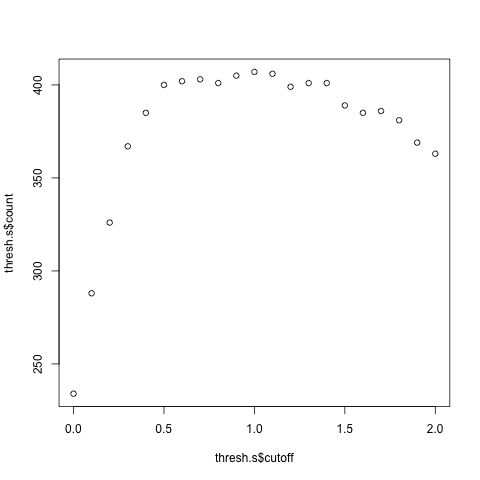

In [14]:
%%R
range = seq(0,2,0.1)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 1.1)

In [15]:
%%R
filter(DA,baseMean>=1.1) %>% mutate(padj = p.adjust(pvalue,"BH")) %>% write.csv("../../SeqData/l2fcQFcombMonths.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [26]:
%%R
l2fc<-read.csv("../../SeqData/l2fcQFcombMonths.csv")
head(l2fc)

         Trtmt       OTU    baseMean       l2FC        SE       pvalue  Kingdom
1 Ferrihydrite    103_43 1023.587871  2.2135456 0.5083457 1.334259e-05 Bacteria
2 Ferrihydrite 41_115941    5.121226 -0.5709078 0.8689352 5.111681e-01 Bacteria
3 Ferrihydrite  72.2_697   33.745985  2.6353915 0.5018330 1.508399e-07 Bacteria
4 Ferrihydrite  49_12296   10.381051  0.3674964 0.9637572 7.029685e-01 Bacteria
5 Ferrihydrite      53_7  643.414139 -1.4369963 0.4236501 6.939930e-04 Bacteria
6 Ferrihydrite      50_8   15.164719 -1.2251377 0.8299986 1.399246e-01 Bacteria
          Phylum               Class            Order            Family
1 Proteobacteria Alphaproteobacteria      Rhizobiales      Rhizobiaceae
2  Acidobacteria      Acidobacteriia Acidobacteriales   Koribacteraceae
3  Acidobacteria     Acidobacteria-6          iii1-15            mb2424
4 Proteobacteria Gammaproteobacteria    Legionellales      Coxiellaceae
5 Proteobacteria  Betaproteobacteria  Burkholderiales  Burkholderiaceae
6 Proteo

In [67]:
%%R
d = l2fc

d$relabund = d$baseMean/sum(d$baseMean)

NPhylum = d %>%
    group_by(Phylum)%>%
    filter(pvalue<0.1)%>%
    summarize(NSig=n())%>%
    arrange(-NSig)

cutoff = 10
NPhylum=droplevels(NPhylum[1:cutoff,1])
NPhylum=levels(as.factor(NPhylum$Phylum))

d<-d[d$Phylum %in% NPhylum,]
d$Phylum<-factor(d$Phylum)

head(d)

         Trtmt       OTU    baseMean       l2FC        SE       pvalue  Kingdom
1 Ferrihydrite    103_43 1023.587871  2.2135456 0.5083457 1.334259e-05 Bacteria
2 Ferrihydrite 41_115941    5.121226 -0.5709078 0.8689352 5.111681e-01 Bacteria
3 Ferrihydrite  72.2_697   33.745985  2.6353915 0.5018330 1.508399e-07 Bacteria
4 Ferrihydrite  49_12296   10.381051  0.3674964 0.9637572 7.029685e-01 Bacteria
5 Ferrihydrite      53_7  643.414139 -1.4369963 0.4236501 6.939930e-04 Bacteria
6 Ferrihydrite      50_8   15.164719 -1.2251377 0.8299986 1.399246e-01 Bacteria
          Phylum               Class            Order            Family
1 Proteobacteria Alphaproteobacteria      Rhizobiales      Rhizobiaceae
2  Acidobacteria      Acidobacteriia Acidobacteriales   Koribacteraceae
3  Acidobacteria     Acidobacteria-6          iii1-15            mb2424
4 Proteobacteria Gammaproteobacteria    Legionellales      Coxiellaceae
5 Proteobacteria  Betaproteobacteria  Burkholderiales  Burkholderiaceae
6 Proteo

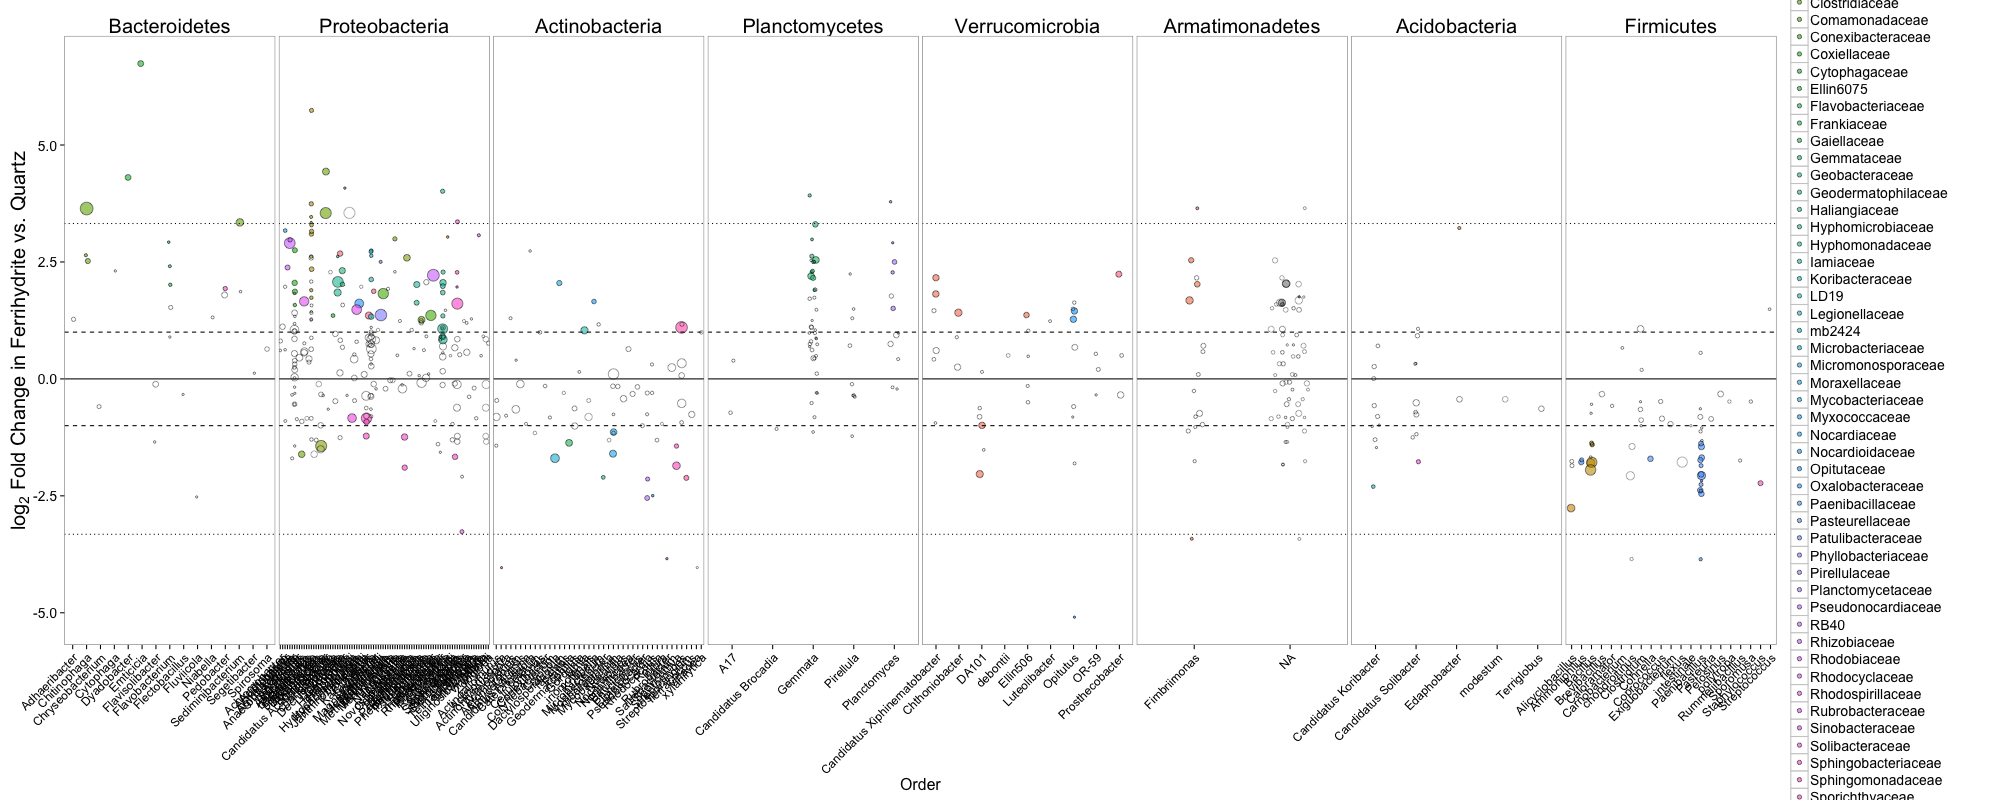

In [70]:
%%R -w 2000 -h 800
# setting the image sizes, then making the figure...

cutoff = 8
# How many phyla do we want to include?

d = l2fc
# setting the dataframe

d$relabund = d$baseMean/sum(d$baseMean)
# calculating relative abundances

NPhylum = d %>%
    group_by(Phylum)%>%
    filter(pvalue<0.1)%>%
    summarize(NSig=n())%>%
    arrange(-NSig)
# Get the Phyla with the most significant OTUs

NPhylum=droplevels(NPhylum[1:cutoff,1])
NPhylum=levels(as.factor(NPhylum$Phylum))

d<-d[d$Phylum %in% NPhylum,]
d$Phylum<-factor(d$Phylum)
# Include only the phyla we selected above

max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values


d$sig = ifelse(d$padj<=0.1,"yes","NS")
d$sig = ifelse(is.na(d$padj),"NS",paste(d$sig))

d.yes = d[d$sig=="yes",]
d.no = d[d$sig=="NS",]

p = ggplot(d, aes(x=Species, y=l2FC))

p = p + geom_point(data=d.yes, aes(x = Genus, y = l2FC, fill = Family, size=relabund), shape = 21, alpha=0.6, position = position_jitter(w = 0.10))
p = p + geom_point(data=d.no, aes(x = Genus, y = l2FC, size=relabund), shape = 21, alpha=0.5, position = position_jitter(w = 0.10))


p = p + facet_grid(~Phylum, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, alpha = 0.4, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)", trans="log")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Order")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," Fold Change in Ferrihydrite vs. Quartz",sep="")))
# sets the label for the y axes.

#p = p + scale_color_continuous(trans="log")    
#p = p + scale_fill_discrete(guide="none")
    
colourCount = length(unique(d$Genus))
getPalette = colorRampPalette(brewer.pal(8, "Dark2"))
p = p + scale_colour_manual(values=c("grey",getPalette(colourCount)))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

###One of the most more abundant OTUs in ferrihydrite is Chitinophaga (Bacteroidetes)

Error in `$<-.data.frame`(`*tmp*`, "SCALE_Y", value = 1L) : 
  replacement has 1 row, data has 0
In addition: Warning message:
In max(panels$ROW) : no non-missing arguments to max; returning -Inf


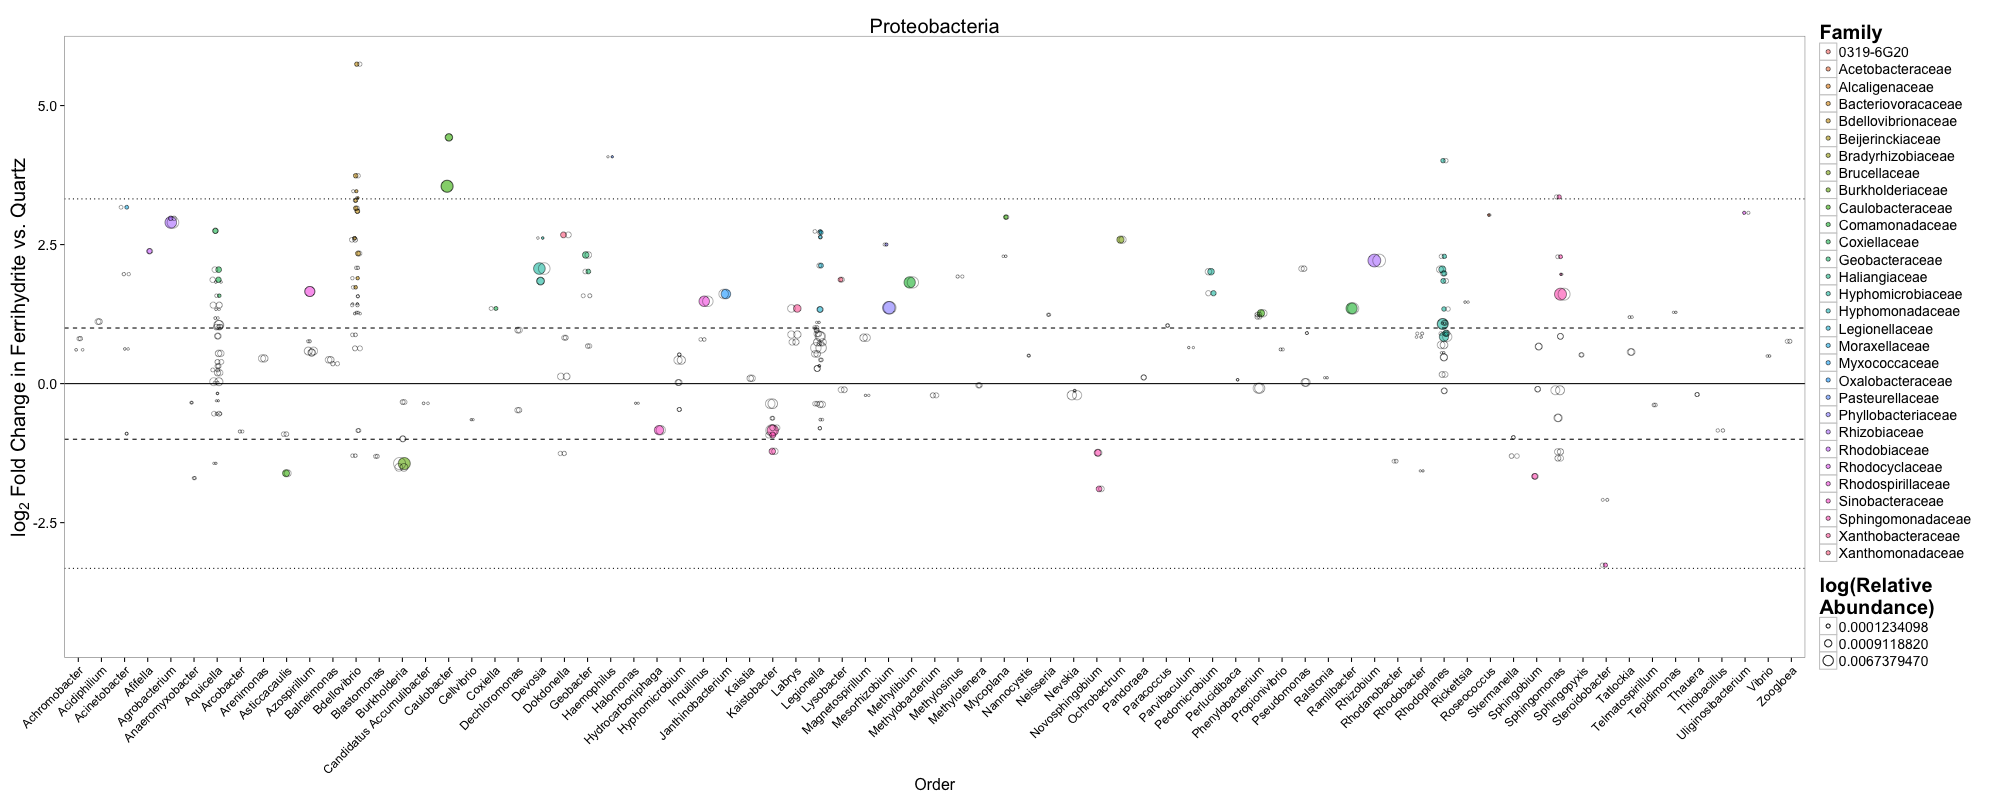

In [75]:
%%R -w 2000 -h 800
# setting the image sizes, then making the figure...

cutoff = 8
# How many phyla do we want to include?

d = l2fc
# setting the dataframe

d$relabund = d$baseMean/sum(d$baseMean)
# calculating relative abundances

NPhylum = d %>%
    group_by(Phylum)%>%
    filter(pvalue<0.1)%>%
    summarize(NSig=n())%>%
    arrange(-NSig)
# Get the Phyla with the most significant OTUs

NPhylum=droplevels(NPhylum[1:cutoff,1])
NPhylum=levels(as.factor(NPhylum$Phylum))

d<-d[d$Phylum %in% "Proteobacteria",]
d$Phylum<-factor(d$Phylum)
# Include only the phyla we selected above

max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values


d$sig = ifelse(d$padj<=0.1,"yes","NS")
d$sig = ifelse(is.na(d$padj),"NS",paste(d$sig))

d.yes = d[d$sig=="yes",]
d.no = d[d$sig=="NS",]

p = ggplot(d, aes(x=Genus, y=l2FC))

p = p + geom_point(data=d.yes, aes(x = Genus, y = l2FC, fill = Family, size=relabund), shape = 21, alpha=0.6, position = position_jitter(w = 0.10))
p = p + geom_point(data=d.no, aes(x = Genus, y = l2FC, size=relabund), shape = 21, alpha=0.5, position = position_jitter(w = 0.10))


p = p + facet_grid(~Phylum, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, alpha = 0.4, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)", trans="log")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Order")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," Fold Change in Ferrihydrite vs. Quartz",sep="")))
# sets the label for the y axes.

#p = p + scale_color_continuous(trans="log")    
#p = p + scale_fill_discrete(guide="none")
    
colourCount = length(unique(d$Genus))
getPalette = colorRampPalette(brewer.pal(8, "Dark2"))
p = p + scale_colour_manual(values=c("grey",getPalette(colourCount)))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

###Caulobacter is one of the more abundant enriched Proteobacteria. It may be similar to <i>Caulobacter crescentus</i>, which can produce two daughter cells - one stalked and the other motile

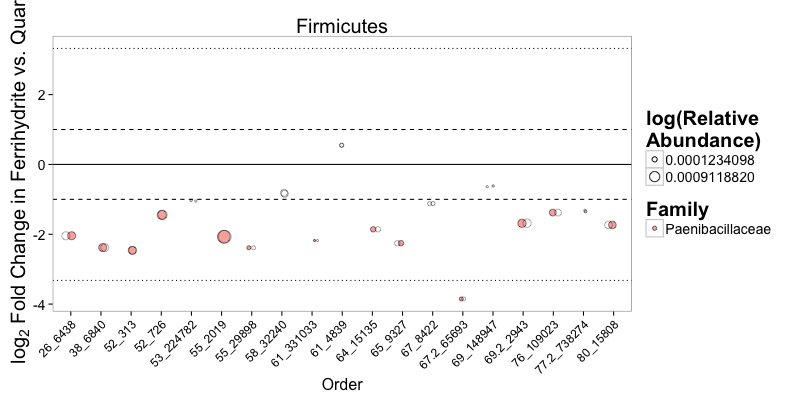

In [78]:
%%R -w 800 -h 400
# setting the image sizes, then making the figure...

cutoff = 8
# How many phyla do we want to include?

d = l2fc
# setting the dataframe

d$relabund = d$baseMean/sum(d$baseMean)
# calculating relative abundances

d = d %>%
    filter(Genus == "Paenibacillus")


d$sig = ifelse(d$padj<=0.1,"yes","NS")
d$sig = ifelse(is.na(d$padj),"NS",paste(d$sig))

d.yes = d[d$sig=="yes",]
d.no = d[d$sig=="NS",]

p = ggplot(d, aes(x=OTU, y=l2FC))

p = p + geom_point(data=d.yes, aes(x = OTU, y = l2FC, fill = Family, size=relabund), shape = 21, alpha=0.6, position = position_jitter(w = 0.10))
p = p + geom_point(data=d.no, aes(x = OTU, y = l2FC, size=relabund), shape = 21, alpha=0.5, position = position_jitter(w = 0.10))


p = p + facet_grid(~Phylum, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, alpha = 0.4, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)", trans="log")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Order")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," Fold Change in Ferrihydrite vs. Quartz",sep="")))
# sets the label for the y axes.

#p = p + scale_color_continuous(trans="log")    
#p = p + scale_fill_discrete(guide="none")
    
colourCount = length(unique(d$Genus))
getPalette = colorRampPalette(brewer.pal(8, "Dark2"))
p = p + scale_colour_manual(values=c("grey",getPalette(colourCount)))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

###Just comparing this to the minerals on their own vs. soil. Quartz and Ferrihydrite both had Paenibacillus enriched - just it seems like in Quartz it was more.